In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

c:\Users\MNIS\Anaconda3\envs\ModelBasedML38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Processing

In [6]:
scaler = StandardScaler()

In [7]:
#Use your own local path please!
path = "./Data/"
file_name = ["train.csv", "test.csv", "submission.csv"]
df_train = pd.read_csv(path + file_name[0])
df_test = pd.read_csv(path + file_name[1])
df_submission = pd.read_csv(path + file_name[2])

In [8]:
df_train['key'] = df_train['key'].fillna(df_train['key'].mean())

In [9]:
df_train['instrumentalness'] = df_train['instrumentalness'].fillna(df_train['instrumentalness'].mean())

In [10]:
df_train['Popularity'] = df_train['Popularity'].fillna(df_train['Popularity'].mean())

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [12]:
df_features = df_train[['Popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature']].copy()
df_features[df_features.columns] = scaler.fit_transform(df_features)

df_train_target = df_train[['Class']].sample(1000)
df_train_target_index = df_train_target.index
df_train_features = df_features.iloc[df_train_target_index].to_numpy()
df_train_target = df_train_target.to_numpy()

df_features_new = df_features
df_features_new[['Class']] = df_train[['Class']]
# df_features_new

df_rest_features = df_features_new.drop(index = df_train_target_index).reset_index()
# df_rest_target = df_train_target.iloc[~df_train_target_index].reset_index()
df_rest_features = df_rest_features.drop(columns = {df_rest_features.columns[0]})
df_test_target = df_rest_features[['Class']].sample(200)
df_test_target_index = df_test_target.index

df_test_features = df_rest_features.iloc[df_test_target_index]
df_test_features = df_test_features.drop(columns={'Class'}).to_numpy()

df_test_target = df_test_target.to_numpy()

# df_rest_features

In [21]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
n_cat = 11 
degF=5
tau=10

### Ancestral Sampling 

In [22]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [-0.50353635  1.3675479  -0.59329893 -0.62066202 -1.62871454  1.3900641
 -0.44082293 -1.12592253  1.44065886 -0.60453056 -0.93508457  0.6109299
 -1.33546168 -0.89074573]


In [23]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))


In [24]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({7.0: 61,
         10.0: 120,
         8.0: 112,
         5.0: 71,
         2.0: 121,
         9.0: 132,
         4.0: 51,
         3.0: 56,
         0.0: 63,
         6.0: 65,
         1.0: 148})

In [25]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.124


### Model implementation with Pyro

In [36]:
def model(X, n_cat, degF, tau, obs=None):
    
    input_dim = X.shape[1]
    
    
    mu_beta = pyro.sample("mu_beta", dist.StudentT(df=torch.ones(n_cat)*degF, 
                                                   loc=torch.zeros(n_cat), 
                                                   scale=torch.ones(n_cat)).to_event()) # Prior for the bias mean      
    sigma_beta  = pyro.sample("sigma_beta",  dist.HalfCauchy(tau*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
    
    beta  = pyro.sample("beta", dist.Normal(mu_beta*torch.ones(n_cat), 
                                            sigma_beta*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coefficents

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [37]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Model training 

In [38]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, degF, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 24137.8
[1000] ELBO: 17068.4
[2000] ELBO: 12207.3
[3000] ELBO: 7765.2
[4000] ELBO: 5651.8
[5000] ELBO: 4066.6
[6000] ELBO: 2989.2
[7000] ELBO: 2518.9
[8000] ELBO: 2110.6
[9000] ELBO: 1960.2
[10000] ELBO: 1897.8
[11000] ELBO: 1841.5
[12000] ELBO: 1824.3
[13000] ELBO: 1825.5
[14000] ELBO: 1808.8
[15000] ELBO: 1806.6
[16000] ELBO: 1788.1
[17000] ELBO: 1798.8
[18000] ELBO: 1800.0
[19000] ELBO: 1786.0


In [41]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

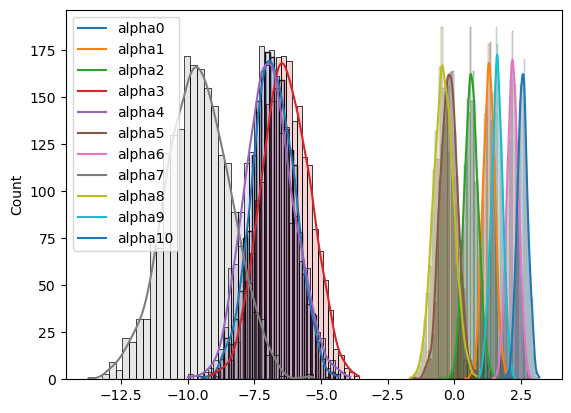

In [43]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

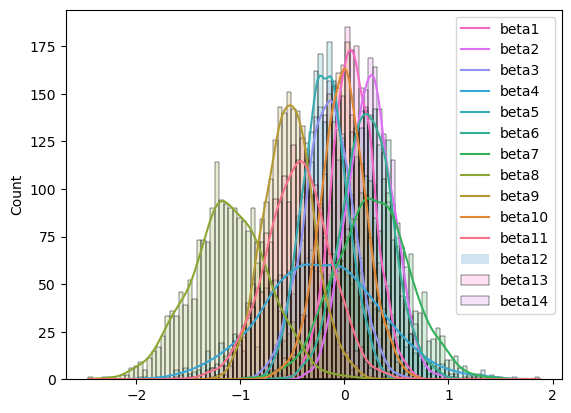

In [44]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [45]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

### Inference and computation of accuracy on the train dataset 

In [46]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_train_pred[n,:][0])

n, p and y  0 [1.07695521e-10 3.53204259e-03 8.35872747e-02 6.67743763e-11
 5.13671487e-10 2.38118114e-03 1.40118573e-02 6.06790542e-09
 8.49411693e-01 1.86839006e-05 4.70572609e-02] 8.0
n, p and y  1 [0.01141746 0.1548118  0.08297815 0.00581958 0.01823241 0.05714518
 0.04679453 0.00109935 0.36138197 0.08707085 0.17324873] 8.0
n, p and y  2 [0.00452075 0.07222311 0.07397205 0.04155083 0.0194146  0.2853417
 0.04457336 0.00037948 0.25900141 0.13299233 0.06603037] 5.0
n, p and y  3 [4.75362632e-04 1.35959915e-02 2.63702883e-02 1.21574489e-02
 2.29811137e-04 8.43901457e-01 7.89745709e-03 6.39430140e-05
 2.09272394e-02 6.77145537e-02 6.66644753e-03] 5.0
n, p and y  4 [0.00802799 0.06215606 0.15836721 0.02084758 0.00192593 0.14778141
 0.08261188 0.04596745 0.27937276 0.09445315 0.0984886 ] 8.0
n, p and y  5 [0.0349623  0.05361273 0.08180706 0.09174835 0.05660934 0.04055207
 0.10547226 0.20134393 0.21181833 0.06056159 0.06151204] 8.0
n, p and y  6 [1.85274115e-01 2.87730954e-06 1.50089111e-06

n, p and y  499 [2.14446728e-02 6.78225681e-03 1.43556301e-02 1.42893993e-02
 8.87796915e-01 9.64571178e-03 4.17751961e-03 1.72049288e-02
 1.47249337e-04 1.75773672e-02 6.57834915e-03] 4.0
n, p and y  500 [0.02772776 0.09271251 0.1546496  0.07162658 0.00600346 0.00985601
 0.08072372 0.02532779 0.35629234 0.06281197 0.11226826] 8.0
n, p and y  501 [0.0037621  0.08952176 0.41112858 0.00228503 0.06098938 0.05528316
 0.18961046 0.03026772 0.02123607 0.03664094 0.0992748 ] 2.0
n, p and y  502 [0.00471302 0.08284404 0.06661877 0.00695537 0.02116143 0.59439522
 0.08843644 0.00155272 0.06403708 0.04050652 0.02877938] 5.0
n, p and y  503 [3.00341245e-01 1.02022054e-03 2.71177545e-03 6.25712315e-02
 1.55625473e-01 3.01099217e-04 1.20016152e-03 4.72344533e-01
 1.22599944e-05 2.96676658e-03 9.05233544e-04] 7.0
n, p and y  504 [1.03886684e-15 1.17462780e-03 9.94930162e-02 1.16751219e-14
 2.60925177e-14 4.35438965e-03 3.81385385e-03 3.33199998e-14
 8.75251672e-01 4.69671742e-06 1.59077438e-02] 8.0
n

n, p and y  988 [0.13033194 0.00256766 0.02243324 0.62863491 0.13691339 0.01622222
 0.00601759 0.02390973 0.00072724 0.0288911  0.00335096] 3.0
n, p and y  989 [1.48118668e-01 1.74977665e-06 1.11741638e-05 7.70089112e-01
 7.44082435e-02 1.63072161e-07 1.03596840e-06 7.36447467e-03
 1.78675074e-09 4.88921953e-06 4.88212372e-07] 3.0
n, p and y  990 [2.00024485e-03 1.09044438e-01 2.82925472e-01 1.13815320e-02
 1.74806039e-02 2.95168896e-02 4.50486026e-02 2.42879246e-04
 2.49666270e-01 3.07048132e-02 2.21988254e-01] 2.0
n, p and y  991 [0.0249801  0.01942764 0.00148965 0.02782867 0.04936939 0.74640866
 0.00854823 0.03481002 0.00718281 0.0765944  0.00336044] 5.0
n, p and y  992 [2.09975051e-04 1.17133242e-01 2.36614428e-01 3.96796562e-04
 4.09969738e-03 3.59934981e-02 7.45542747e-02 3.55980980e-05
 2.99801748e-01 1.65259183e-02 2.14634823e-01] 8.0
n, p and y  993 [1.38430181e-04 4.46419988e-02 5.38725020e-02 8.45262616e-04
 3.45851699e-03 7.04007888e-02 2.66418803e-02 2.97870417e-05
 6.4263

In [47]:
y_train_pred = y_train_pred[:,0]

In [48]:
df_train_target.flatten()

array([10, 10, 10,  6,  6, 10, 10,  1,  8,  9, 10,  9,  9,  2, 10,  9,  8,
       10,  9, 10,  1,  6,  8,  5,  9,  9, 10,  2,  0,  5,  6,  6,  1,  8,
        1,  4,  6,  1,  8, 10, 10,  9, 10,  7,  9, 10, 10,  0,  8, 10,  6,
        2, 10,  5, 10, 10,  0,  6, 10,  6, 10,  0, 10, 10,  1, 10,  0, 10,
       10,  7,  8,  1,  8,  0, 10,  5,  6, 10,  8, 10,  8,  2,  8,  6,  9,
        6, 10,  6,  9, 10,  9,  6,  5,  5,  8,  6,  8,  5,  6,  6,  7, 10,
        8,  6, 10,  1,  7,  8,  9,  8,  9,  9, 10,  3,  8,  9,  8,  6,  6,
        5,  9,  2,  1,  0,  5,  9,  5, 10,  6, 10,  6,  3,  6,  9,  8,  9,
        1,  9,  6, 10,  9,  8,  1, 10,  9,  0,  8,  5, 10,  9,  8,  8,  9,
       10, 10, 10,  2,  9, 10,  9,  9,  9, 10,  3,  1, 10,  9,  9,  1,  6,
        9,  9,  9, 10,  2,  6,  6,  4, 10, 10, 10, 10, 10,  2,  1, 10, 10,
       10,  6,  0,  1,  5,  9,  1,  8,  8,  6, 10,  1,  2, 10,  2, 10,  6,
        2,  6, 10,  2,  6,  2,  0,  6,  1,  6, 10, 10,  2,  1,  9, 10,  6,
       10, 10,  8, 10, 10

In [49]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.261


### Inference and computation of accuracy on the test dataset 

In [50]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_test_pred[n,:])

n, p and y  0 [0.1258328  0.04504653 0.02579644 0.00553954 0.47206513 0.04542537
 0.04248484 0.08137492 0.03728573 0.0641318  0.05501687] [4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
n, p and y  1 [1.50018811e-03 1.62023046e-01 7.86649593e-02 1.63385863e-03
 3.47693829e-02 1.46394836e-02 4.33059555e-02 8.03966036e-05
 3.29984978e-01 9.32189232e-02 2.40178828e-01] [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
n, p and y  2 [9.23240892e-06 5.27207100e-03 3.79961011e-03 5.68458671e-06
 3.28274808e-06 3.27919799e-03 3.62648914e-03 5.80931331e-07
 9.62827881e-01 1.02040352e-03 2.01555669e-02] [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
n, p and y  3 [0.16785694 0.01190931 0.00437849 0.06825905 0.12396593 0.05811197
 0.01658888 0.39364373 0.04083714 0.10514448 0.00930408] [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
n, p and y  4 [0.1442972  0.01544959 0.03129123 0.2964268  0.01407038 0.15872565
 0.0232917  0.1836779  0.00261453 0.12505537 0.00509965] [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
n, p and y  5 [0.23655356 0.03102481 0.105062

In [51]:
y_test_pred = y_test_pred[:,0]

In [52]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.27



DOUBLE CHECK

* fillna using KNN inputer 
* is averaging the betas giving the best result for the predictions 
* is ancentral sampling correct? 

TODO

* Have priors for mean and variance for betas and alphas - parameter tuning 
* Consider different distributions for priors
* Train model on more data - currently 100 
* Extend it with FFNN 
* Feature engineer name and album name and retrain logistic regression model using these attributes